# Semantic segmentation of aerial images with deep networks

This notebook presents a straightforward PyTorch implementation of a Fully Convolutional Network for semantic segmentation of aerial images. More specifically, we aim to automatically perform scene interpretation of images taken from a plane or a satellite by classifying every pixel into several land cover classes.

As a demonstration, we are going to use the [SegNet architecture](http://mi.eng.cam.ac.uk/projects/segnet/) to segment aerial images over the cities of Vaihingen and Potsdam. The images are from the [ISPRS 2D Semantic Labeling dataset](http://www2.isprs.org/commissions/comm3/wg4/results.html). We will train a network to segment roads, buildings, vegetation and cars.

This work is a PyTorch implementation of the baseline presented in ["Beyond RGB: Very High Resolution Urban Remote Sensing With Multimodal Deep Networks "](https://hal.archives-ouvertes.fr/hal-01636145), *Nicolas Audebert*, *Bertrand Le Saux* and *Sébastien Lefèvre*, ISPRS Journal, 2018.

## Requirements

This notebook requires a few useful libraries, e.g. `torch`, `scikit-image`, `numpy` and `matplotlib`. You can install everything using `pip install -r requirements.txt`.

This is expected to run on GPU, and therefore you should use `torch` in combination with CUDA/cuDNN. This can probably be made to run on CPU but be warned that:
  * you have to remove all calls to `torch.Tensor.cuda()` throughout this notebook,
  * this will be very slow.
  
A "small" GPU should be enough, e.g. this runs fine on a 4.7GB Tesla K20m. It uses quite a lot of RAM as the dataset is stored in-memory (about 5GB for Vaihingen). You can spare some memory by disabling the caching below. 4GB should be more than enough without caching.

In [1]:
# imports and stuff
import numpy as np

from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
from datetime import datetime

import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable


In [2]:
# print(torch.__version__)
# print(torch.nn.__file__)
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Fri_Feb__8_19:08:17_PST_2019
Cuda compilation tools, release 10.1, V10.1.105


In [3]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
 
print(os.environ['CUDA_VISIBLE_DEVICES'])

2,3


## Parameters

There are several parameters than can be tuned to use this notebook with different datasets. The default parameters are suitable for the ISPRS dataset, but you can change them to work with your data.

### Examples

  * Binary classification: `N_CLASSES = 2`
  * Multi-spectral data (e.g. IRRGB): `IN_CHANNELS = 4`
  * New folder naming convention : `DATA_FOLDER = MAIN_FOLDER + 'sentinel2/sentinel2_img_{}.tif'`

In [4]:
# Parameters
WINDOW_SIZE = (256, 256) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
FOLDER = "../ISPRS_DATASET/" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 4 # Number of samples in a mini-batch

LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

DATASET = 'Vaihingen'

if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER + 'Potsdam/'
    DATA_FOLDER = MAIN_FOLDER + '3_Ortho_IRRG/top_potsdam_{}_{}_IRRG.tif'
    LABEL_FOLDER = MAIN_FOLDER + '5_Labels_for_participants/top_potsdam_{}_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'    
elif DATASET == 'Vaihingen':
    MAIN_FOLDER = FOLDER + 'Vaihingen/'
    DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
    LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'
#     ERODED_FOLDER = MAIN_FOLDER + 'gts_eroded_for_participants/top_mosaic_09cm_area{}_noBoundary.tif' # original line
    ERODED_FOLDER = MAIN_FOLDER + 'gts_eroded_complete/top_mosaic_09cm_area{}.tif'

## Visualizing the dataset

First, let's check that we are able to access the dataset and see what's going on. We use ```scikit-image``` for image manipulation.

As the ISPRS dataset is stored with a ground truth in the RGB format, we need to define the color palette that can map the label id to its RGB color. We define two helper functions to convert from numeric to colors and vice-versa.

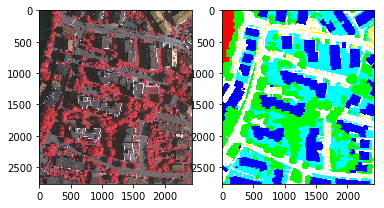

Ground truth in numerical format has shape (2767,2428) : 
 [[5 5 5 ... 1 1 1]
 [5 5 5 ... 1 1 1]
 [5 5 5 ... 1 1 1]
 ...
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]]


In [5]:
# ISPRS color palette
# Let's define the standard ISPRS color palette
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# We load one tile from the dataset and we display it
img = io.imread(DATA_FOLDER.format(2,10))
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread(LABEL_FOLDER.format(2,10))
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

# We also check that we can convert the ground truth into an array format
array_gt = convert_from_color(gt)
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)

/home/mmvc/anaconda3/envs/segnet/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


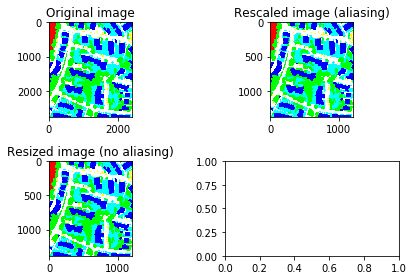

In [6]:
from skimage.transform import rescale, resize, downscale_local_mean

image = gt
image_rescaled = rescale(image, 0.5, anti_aliasing=True)
image_resized = resize(image, (image.shape[0] // 2, image.shape[1] // 2),
                       anti_aliasing=True)
# image_downscaled = downscale_local_mean(image, (2, 2))

fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(image_rescaled, cmap='gray')
ax[1].set_title("Rescaled image (aliasing)")

ax[2].imshow(image_resized, cmap='gray')
ax[2].set_title("Resized image (no aliasing)")

# ax[3].imshow(image_downscaled, cmap='gray')
# ax[3].set_title("Downscaled image (no aliasing)")

# ax[0].set_xlim(0, 512)
# ax[0].set_ylim(512, 0)
plt.tight_layout()
plt.show()

In [7]:
ls ./ISPRS_DATASET/Potsdam/5_Labels_for_participants

ls: cannot access './ISPRS_DATASET/Potsdam/5_Labels_for_participants': No such file or directory


We need to define a bunch of utils functions.

In [8]:
# Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))
        pass
    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

## Loading the dataset

We define a PyTorch dataset (```torch.utils.data.Dataset```) that loads all the tiles in memory and performs random sampling. Tiles are stored in memory on the fly.

The dataset also performs random data augmentation (horizontal and vertical flips) and normalizes the data in [0, 1].

In [9]:
# Dataset class

class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

In [10]:
# Dataset class

class ISPRS_val(torch.utils.data.Dataset):
    def __init__(self, ids,length, data_files=DATA_FOLDER, label_files=LABEL_FOLDER, augmentation=True):
        super(ISPRS_val, self).__init__()
        
        self.augmentation = augmentation
        
        self.length = length
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
     
 
    def __len__(self):
        # Default epoch size is 10 000 samples
        return self.length
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
 
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
           
        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]

        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

## Network definition

We can now define the Fully Convolutional network based on the SegNet architecture. We could use any other network as drop-in replacement, provided that the output has dimensions `(N_CLASSES, W, H)` where `W` and `H` are the sliding window dimensions (i.e. the network should preserve the spatial dimensions).

In [11]:
from torch.nn import Module, Parameter

# Building the context encoding module

 
def scaled_l2_plus_aggregate(X, C, S):
    """
    scaled_l2 distance
    Args:
        X (b*n*d):  original feature input
        C (k*d):    code words, with k codes, each with d dimension
        S (k):      scale cofficient
    Return:
        D (b*n*k):  relative distance to each code
    Note:
        apparently the X^2 + C^2 - 2XC computation is 2x faster than
        elementwise sum, perhaps due to friendly cache in gpu
    """
    assert X.shape[-1] == C.shape[-1], "input, codeword feature dim mismatch"
    assert S.numel() == C.shape[0], "scale, codeword num mismatch"
    """
    # simplier but slower
    X = X.unsqueeze(2)
    C = C[None, None,...]
    norm = torch.norm(X-C, dim=-1).pow(2.0)
    scaled_norm = S * norm
    """
    X = X.unsqueeze(2) #[b, n, 1, d]
    C = C[None, None,...]  # [k, d] -> [1, 1, k, d]
    norm = torch.norm(X-C, dim=-1).pow(2.0)
    scaled_norm = S * norm
    A = F.softmax(scaled_norm, dim=2) 
    A = A.unsqueeze(-1)  # [b, n, k] -> [b, n, k, 1]
    R = (X - C) * A  # [b, n, k, d]
    E = R.sum(dim=1)  # [b, k, d]
    
#     return D
    # return scaled_norm
    return E

def scaled_l2(X, C, S):
    """
    scaled_l2 distance
    Args:
        X (b*n*d):  original feature input
        C (k*d):    code words, with k codes, each with d dimension
        S (k):      scale cofficient
    Return:
        D (b*n*k):  relative distance to each code
    Note:
        apparently the X^2 + C^2 - 2XC computation is 2x faster than
        elementwise sum, perhaps due to friendly cache in gpu
    """
    assert X.shape[-1] == C.shape[-1], "input, codeword feature dim mismatch"
    assert S.numel() == C.shape[0], "scale, codeword num mismatch"
    """
    # simplier but slower
    X = X.unsqueeze(2)
    C = C[None, None,...]
    norm = torch.norm(X-C, dim=-1).pow(2.0)
    scaled_norm = S * norm
    """
    X = X.unsqueeze(2)
    C = C[None, None,...]
    norm = torch.norm(X-C, dim=-1).pow(2.0)
    scaled_norm = S * norm
    return scaled_norm


def aggregate(A, X, C):
    """
    aggregate residuals from N samples
    Args:
        A (b*n*k):  weight of each feature contribute to code residual
        X (b*n*d):  original feature input
        C (k*d):    code words, with k codes, each with d dimension
    Return:
        E (b*k*d):  residuals to each code
    """
    assert X.shape[-1] == C.shape[-1], "input, codeword feature dim mismatch"
    assert A.shape[:2] == X.shape[:2], "weight, input dim mismatch"
    b, n, d = X.shape
    X = X.unsqueeze(2)  # [b, n, d] -> [b, n, 1, d]
    C = C[None, None, ...]  # [k, d] -> [1, 1, k, d]
    A = A.unsqueeze(-1)  # [b, n, k] -> [b, n, k, 1]
    R = (X - C) * A  # [b, n, k, d]
    E = R.sum(dim=1)  # [b, k, d]
    
    # This was the version I attempted to generate
#     X = X.sum(dim=1).view(b,d) #[b, n, d] -> [b,d]
#     X = X.unsqueeze(1) #[ b, 1, d]
#     C = C[None, ...]  # [k, d] -> [1, k, d]
#     E = X + C
    return E

class Encoding(Module):
    def __init__(self, D, K):
        super(Encoding, self).__init__()
        # init codewords and smoothing factor
        self.D, self.K = D, K
        self.codewords = Parameter(torch.Tensor(K, D), requires_grad=True)
        self.scale = Parameter(torch.Tensor(K), requires_grad=True)
        self.reset_params()

    def reset_params(self):
        std1 = 1./((self.K*self.D)**(1/2))
        self.codewords.data.uniform_(-std1, std1)
        self.scale.data.uniform_(-1, 0)

    def forward(self, X):
        # input X is a 4D tensor
        assert(X.size(1) == self.D)
        B, D = X.size(0), self.D
        if X.dim() == 3:
            # BxDxN => BxNxD
            X = X.transpose(1, 2).contiguous()
        elif X.dim() == 4:
            # BxDxHxW => Bx(HW)xD
            X = X.view(B, D, -1).transpose(1, 2).contiguous()
        else:
            raise RuntimeError('Encoding Layer unknown input dims!')
        # assignment weights BxNxK
        A = F.softmax(scaled_l2(X, self.codewords, self.scale), dim=2)

        aggregate
        E = aggregate(A, X, self.codewords)

#         E = scaled_l2_plus_aggregate(X, self.codewords, self.scale)
    
        return E

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'N x ' + str(self.D) + '=>' + str(self.K) + 'x' \
            + str(self.D) + ')'
    
    
class EncModule(nn.Module):
    def __init__(self, in_channels, nclass, ncodes=32, se_loss=True, norm_layer=None):
        super(EncModule, self).__init__()
        self.se_loss = se_loss
        self.encoding = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            Encoding(D=in_channels, K=ncodes),
            nn.ReLU(inplace=True),
            Mean(dim=1))
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels),
            nn.Sigmoid())
        if self.se_loss:
            self.selayer = nn.Linear(in_channels, nclass)

    def forward(self, x):
        en = self.encoding(x)
        b, c, _, _ = x.size()
#         print("b,cxsize", x.size())
        gamma = self.fc(en)
#         print("gamma_size", gamma.size())
        y = gamma.view(b, c, 1, 1)
#         print("y_size", y.size())
        outputs = [F.relu_(x + x * y)]
        if self.se_loss:
            outputs.append(self.selayer(en))
        return tuple(outputs)

    
class EncHead(nn.Module):
    def __init__(self, in_channels, out_channels, se_loss=True, lateral=True,
                 norm_layer=None, up_kwargs=None):
        super(EncHead, self).__init__()
        self.se_loss = se_loss
        self.lateral = lateral
        self.up_kwargs = up_kwargs
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels, 512, 3, padding=1, bias=False),
            nn.ReLU(inplace=True))
        if lateral:
            self.connect = nn.ModuleList([
                nn.Sequential(
                    nn.Conv2d(512, 512, kernel_size=1, bias=False),
                    nn.ReLU(inplace=True)),
                nn.Sequential(
                    nn.Conv2d(1024, 512, kernel_size=1, bias=False),
                    nn.ReLU(inplace=True)),
            ])
            self.fusion = nn.Sequential(
                    nn.Conv2d(3*512, 512, kernel_size=3, padding=1, bias=False),
                    nn.ReLU(inplace=True))
        self.encmodule = EncModule(512, out_channels, ncodes=32,
            se_loss=se_loss, norm_layer=norm_layer)
        self.conv6 = nn.Sequential(nn.Dropout2d(0.1, False),
                                   nn.Conv2d(512, out_channels, 1))

    def forward(self, *inputs):
        feat = self.conv5(inputs[-1])
        if self.lateral:
            
            c2 = self.connect[0](inputs[1])
            c3 = self.connect[1](inputs[2])
            
            feat = self.fusion(torch.cat([feat, c2, c3], 1))    
        
        outs = list(self.encmodule(feat))
        outs[0] = self.conv6(outs[0])

        return tuple(outs)

    

In [12]:
from torch.autograd import Variable, Function
from torch.autograd.function import once_differentiable


try:
    from queue import Queue
except ImportError:
    from Queue import Queue

class Mean(nn.Module):
    def __init__(self, dim, keep_dim=False):
        super(Mean, self).__init__()
        self.dim = dim
        self.keep_dim = keep_dim

    def forward(self, input):
        return input.mean(self.dim, self.keep_dim)
    
     



In [13]:

class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)

        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
#         self.final_downsample = nn.AvgPool2d((3), stride=2)
        self.pool_context = nn.MaxPool2d(4, return_indices=True)

        self.context_encoder = EncHead(64, 64, se_loss=False, norm_layer=None,
                    lateral=False, up_kwargs=None) #need to try to set the SE loss to false later?
        
        self.unpool_context = nn.MaxUnpool2d(4)
        
        self.conv_final = nn.Conv2d(64, out_channels, 3, padding=1)

        self.apply(self.weight_init)
        

    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
#         print("AFTER CONV 4_3_D>>", x.shape)
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
#         print("AFTER CONV 4_2_D>>", x.shape)
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
#         print("AFTER CONV 4_1_D>>", x.shape)
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
#         print("AFTER CONV 3_3_D>>", x.shape)
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
#         print("AFTER CONV 3_2_D>>", x.shape)
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
#         print("AFTER CONV 3_1_D>>", x.shape)
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        # Decoder block 1 (pooling in last layer to instead of convolution)
        
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))        
        #Context Encoder
#         print("XSHAPE>>", x.shape)
#         x = self.conv1_1_D(x)
#         print("PRE-CONTEXT POOLING>", x.shape)     
        
        size_x = x.size()
#         print("SIZEX", size_x)
        
        y = x
        x, mask_context = self.pool_context(x)
        
#         print("AFTER POOLING>>", x.shape)

        x = list(self.context_encoder(x))[0]
#         print("AFTER CONTEXT>>", x.shape)
        
        x =  self.unpool_context(x, mask_context, output_size=size_x)
#         print("AFTER UNPOOLING>>", x.shape)
        
        x = x + y #skip connection to retain information!
#         print("AFTER SKIP>>", x.shape)
        
        x = F.log_softmax(self.conv_final(x))
#         print("AFTER FINAL CONV>>", x.shape)

#         raise


 


        
 
        return x

We can now instantiate the network using the specified parameters. By default, the weights will be initialized using the [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf).

In [14]:
# instantiate the network
net = SegNet()

/home/mmvc/anaconda3/envs/Rx/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  


#### We download and load the pre-trained weights from VGG-16 on ImageNet. This step is optional but it makes the network converge faster. We skip the weights from VGG-16 that have no counterpart in SegNet.

In [15]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

Then, we load the network on GPU.

In [16]:
# net.cuda()

net = torch.nn.DataParallel(net, device_ids=[0]).cuda()
 

### Loading the data

We now create a train/test split. If you want to use another dataset, you have to adjust the method to collect all filenames. In our case, we specify a fixed train/test split for the demo.

In [17]:
##### Load the datasets
if DATASET == 'Potsdam':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["_".join(f.split('_')[3:5]) for f in all_files]
elif DATASET == 'Vaihingen':
    #all_ids = 
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]
# Random tile numbers for train/test split
# train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
# test_ids = list(set(all_ids) - set(train_ids))

# Exemple of a train/test split on Vaihingen :
train_ids = ['1', '5', '23', '26', '7', '11', '13', '30', '17', '32', '34', '37']
test_ids = ['3', '21', '15', '28']

# train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37', '5', '21', '15', '30']
# test_ids = list(set(all_ids) - set(train_ids))

print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Tiles for training :  ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37', '5', '21', '15', '30']
Tiles for testing :  ['4', '6', '12', '35', '24', '2', '8', '16', '14', '22', '33', '27', '29', '20', '38', '10', '31']


In [18]:
train_set[0][0].size(), train_set[0][1].size()

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

### Designing the optimizer

We use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the ``torch.optim.lr_scheduler`` to reduce the learning rate by 10 after 25, 35 and 45 epochs.

In [19]:
base_lr = 0.0001
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

In [20]:
from IPython.display import clear_output

#Added these

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()
    
    acc = np.zeros(1000000)
    mean_acc = np.zeros(1000000)

    criterion = nn.NLLLoss2d(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        batch_acc = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
#             print("CHECK")

#             replaced the below lines with everything up to loss.backward
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
#             loss = net(data, target)
# #             print(loss.shape)
#             loss = loss.sum()
            
            
            
            loss.backward()
            optimizer.step()
            
#             losses[iter_] = loss.data[0] #original version
            losses[iter_] = loss.item()
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
            gt = target.data.cpu().numpy()[0]
            
            acc[iter_] = 100 * float(np.count_nonzero(pred == gt)) / gt.size
            mean_acc[iter_] = np.mean(acc[max(0,iter_-100):iter_])

#             print("SHAPES", output.shape, target.shape)
            if iter_ % 100 == 0:
#                 pass
                clear_output()       
#                 acc[iter_] = val_acc(net, val_ids)
#                 print("acc[iter_]", acc[iter_])

                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                
# #                 print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
# #                     e, epochs, batch_idx, len(train_loader),
# #                     100. * batch_idx / len(train_loader), loss.data[0], accuracy(pred, gt)))
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
#                     100. * batch_idx / len(train_loader), loss.data, accuracy(pred, gt)))
                    100. * batch_idx / len(train_loader), losses[iter_], acc[iter_] ))

                plt.plot(mean_losses[:iter_]) and plt.show() 
                plt.plot(mean_acc[:iter_]) and plt.show() #I added

                plt.savefig('fintune_loss.png')
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
                
  
            iter_ += 1
            
           
            del(data, target, loss)    
                
#         if e % save_epoch == 0:
        if e % 1 == 0:

            
            # We validate with the largest possible stride for faster computing
#             acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
#             torch.save(net.state_dict(), './segnet256_epoch{}_{}'.format(e, acc))
            #for some reason, we were originally saving the file below with epoch number e+35 but now I am just using e directly
            torch.save(net.state_dict(), './segnet_adjusted_results/segnet256_fintune_epoch{}of{}_{}'.format(e, epochs, accuracy(pred, gt) ))
    torch.save(net.state_dict(), './segnet_adjusted_results/segnet_fintune_final')

### Training the network

Let's train the network for 50 epochs. The `matplotlib` graph is periodically udpated with the loss plot and a sample inference. Depending on your GPU, this might take from a few hours (Titan Pascal) to a full day (old K20).

Train (epoch 6/40) [1800/2500 (72%)]	Loss: 0.514627	Accuracy: 76.1138916015625


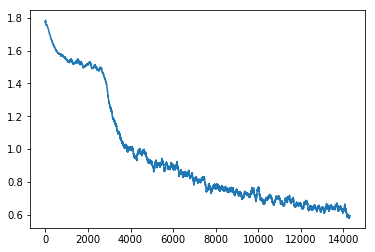

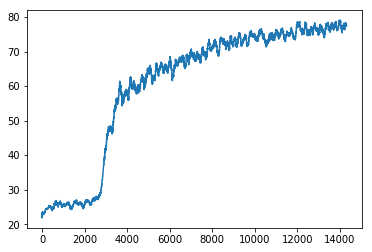

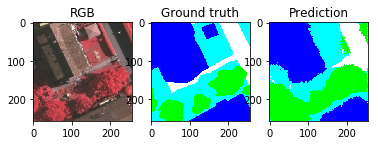

KeyboardInterrupt: 

In [22]:
# train(net, optimizer, 15, scheduler)
train(net, optimizer, 40, scheduler) #using 100 to see where it stops before using that as stopping point

In [ ]:
def load_checkpoint(model, optimizer, filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename) 
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
#         losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch#, losslogger

# net, optimizer, start_epoch = load_checkpoint(net, optimizer, filename='./checkpoints_SegNet/segnet256_epoch35_88.73044107893148')
# filename='./checkpoints_SegNet/segnet256_epoch35_88.73044107893148'
# checkpoint = torch.load(filename)

### Testing the network

Now that the training has ended, we can load the final weights and test the network using a reasonable stride, e.g. half or a quarter of the window size. Inference time depends on the chosen stride, e.g. a step size of 32 (75% overlap) will take ~15 minutes, but no overlap will take only one minute or two.

In [ ]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
     
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

#     for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False): #original line
    for _, (img, gt, gt_e) in enumerate(zip(test_images, test_labels, eroded_labels)):

        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
#         for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
        for _, coords in enumerate(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size))):
  
            # Display in progress results
#             if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
#                     _pred = np.argmax(pred, axis=-1)
#                     fig = plt.figure()
#                     fig.add_subplot(1,3,1)
#                     plt.imshow(np.asarray(255 * img, dtype='uint8'))
#                     fig.add_subplot(1,3,2)
#                     plt.imshow(convert_to_color(_pred))
#                     fig.add_subplot(1,3,3)
#                     plt.imshow(gt)
#                     clear_output()
#                     plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        # Compute some metrics
        metrics(pred.ravel(), gt_e.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
        
        now = datetime.now()
        end_time = now.strftime("%H:%M:%S")
        print("Time Range =", start_time, end_time)
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

In [ ]:
# net.load_state_dict(torch.load('./segnet_adjusted_results/segnet256_fintune_epoch57of100_99.676513671875')) #  
net.load_state_dict(torch.load('./segnet_adjusted_results/segnet256_fintune_epoch67of100_93.35784912109375')) #  

acc, all_preds, all_gts = test(net, test_ids, all=True, stride=32)
print('overall accuracy: %f' % (acc))

### Saving the results

We can visualize and save the resulting tiles for qualitative assessment.

In [ ]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./inference_tiles/inference_tile_{}.png'.format(id_), img)

##finetune

In [ ]:
# Load the datasets
if DATASET == 'Potsdam':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["_".join(f.split('_')[3:5]) for f in all_files]
elif DATASET == 'Vaihingen':
    #all_ids = 
    all_files = sorted(glob(DATA_FOLDER.replace('{}', '*')))
    all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]
print(len(all_ids), all_ids)

In [ ]:
# train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37', '5', '21', '15', '30']
# test_ids = list(set(all_ids) - set(train_ids))

print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

In [ ]:
def inference(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

    for img, in tqdm(zip(test_images), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
#                     fig = plt.figure()
#                     fig.add_subplot(1,3,1)
#                     plt.imshow(np.asarray(255 * img, dtype='uint8'))
#                     fig.add_subplot(1,3,2)
#                     plt.imshow(convert_to_color(_pred))
#                     fig.add_subplot(1,3,3)
#                     plt.imshow(gt)
#                     clear_output()
#                     plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        clear_output()
    return all_preds


In [ ]:
net.load_state_dict(torch.load('./segnet_adjusted_results/segnet_fintune_final'))
all_preds = inference(net, test_ids, all=True, stride=32)
# print('overall accuracy: %f' % (acc))

for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./inference_SegNet/submission/top_mosaic_09cm_area{}_class.tif'.format(id_), img)


In [ ]:
ls inference_SegNet/submission

In [ ]:
len(all_preds),len(test_ids)